# Выбор локации для скважины

## Описание проекта

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Имеются пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Описание данных

Данные геологоразведки трёх регионов находятся в файлах:

- `/datasets/geo_data_0.csv`.
- `/datasets/geo_data_1.csv`. 
- `/datasets/geo_data_2.csv`. 
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

### План исследования

1. Загрузить и подготовить данные.
2. Обучить и проверить модели для каждого региона:
   Для этого необходимо:  
   - Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
   - Обучить модель и сделать предсказания на валидационной выборке.
   - Сохранить предсказания и правильные ответы на валидационной выборке.
   - Вывести на экран средний запас предсказанного сырья и RMSE модели.
   - Анализ результатов.
3. Подготовить расчёт прибыли:
   Для этого необходимо:
   - Все ключевые значения для расчётов сохранить в отдельных переменных.
   - Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
   - Сделать выводы по этапу подготовки расчёта прибыли.
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
   Для этого необходимо:
   - Выбрать скважины с максимальными значениями предсказаний.
   - Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
   - Рассчитать прибыль для полученного объёма сырья.
   
   Посчитать риски и прибыль для каждого региона:
   Для этого необходимо:
   - Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
   - Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
   - Сделать выводы: предложить регион для разработки скважин и обосновать выбор.

### Дополнительные условия

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

### Импорт необходимыx библиотек для работы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import warnings

warnings.filterwarnings('ignore')

RANDOM = 12345  # значение random_state для моделирования

### Загрузка данных из файлов `geo_data_0.csv`,  `geo_data_1.csv` и `geo_data_2 .csv` в датафреймы `data_0`, `data_1` и `data_2` соответственно.

In [2]:
try:
    data_0 = pd.read_csv("/datasets/geo_data_0.csv")  # датасет для Региона 1
    data_1 = pd.read_csv("/datasets/geo_data_1.csv")  # датасет для Региона 2
    data_2 = pd.read_csv("/datasets/geo_data_2.csv")  # датасет для Региона 3
except FileNotFoundError:
    data_0 = pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_0.csv")
    data_1 = pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_1.csv")
    data_2 = pd.read_csv("https://code.s3.yandex.net/datasets/geo_data_2.csv")

### Посмотрим правильность загрузки данных методом `head()` и информацию по дарафреймам методом `info()`

In [3]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Проверка на наличие пропущенных значений

In [9]:
data = [data_0, data_1, data_2]
for i in range(3):
    print(
        f"Пропущенных значений в датафрейме data_{i}:\n {data[i].isnull().sum()}\n"
    )

Пропущенных значений в датафрейме data_0:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропущенных значений в датафрейме data_1:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Пропущенных значений в датафрейме data_2:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



**Пропущенные значения отсутствуют.**

### Проверка на наличие дубликатов

In [10]:
for i in range(3):
    print(
        f"Пропущенных значений в датафрейме data_{i}: {data[i].duplicated().sum()}\n"
    )

Пропущенных значений в датафрейме data_0: 0

Пропущенных значений в датафрейме data_1: 0

Пропущенных значений в датафрейме data_2: 0



**Дубликаты отсутствуют.**

### Проверка на уникальные значения

In [11]:
for i in range(3):
    print(f"Уникальные начения в датафрейме data_{i}:\n {data[i].nunique()}\n")

Уникальные начения в датафрейме data_0:
 id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Уникальные начения в датафрейме data_1:
 id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

Уникальные начения в датафрейме data_2:
 id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64



Видно что, `id` повторяется в датафреймах. И странное значение `product` в одном из датафреймов.

In [12]:
data_0['id'].value_counts()

fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
        ..
x8osI    1
gZ7tR    1
Zw8hj    1
zcrQO    1
1CWhH    1
Name: id, Length: 99990, dtype: int64

In [13]:
data_1['id'].value_counts()

wt4Uk    2
LHZR0    2
5ltQ6    2
bfPNe    2
kBEdx    1
        ..
eup2F    1
5Z8yO    1
HwvM0    1
MZgPf    1
relB0    1
Name: id, Length: 99996, dtype: int64

In [14]:
data_2['id'].value_counts()

VF7Jo    2
KUPhW    2
xCHr8    2
Vcm5J    2
fwXo0    1
        ..
bdHH6    1
copuS    1
hZYbu    1
7K1cP    1
V9kWn    1
Name: id, Length: 99996, dtype: int64

Проверка дублированных `id` в каждом из датафреймов

In [15]:
data_0[data_0['id'] == 'fiKDv']

,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


In [16]:
data_1[data_1['id'] == 'wt4Uk']

,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [17]:
data_2[data_2['id'] == 'VF7Jo']

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


Видно, что при одинаковых `id` все остальные данные разные. Возможно это ошибки  `id`. Но удалять строки будет не корретно. Оставим как есть.

Странные значения `product` рассмотрем наглядно на гистограмме

### Гистограмма распределения по объему скважин

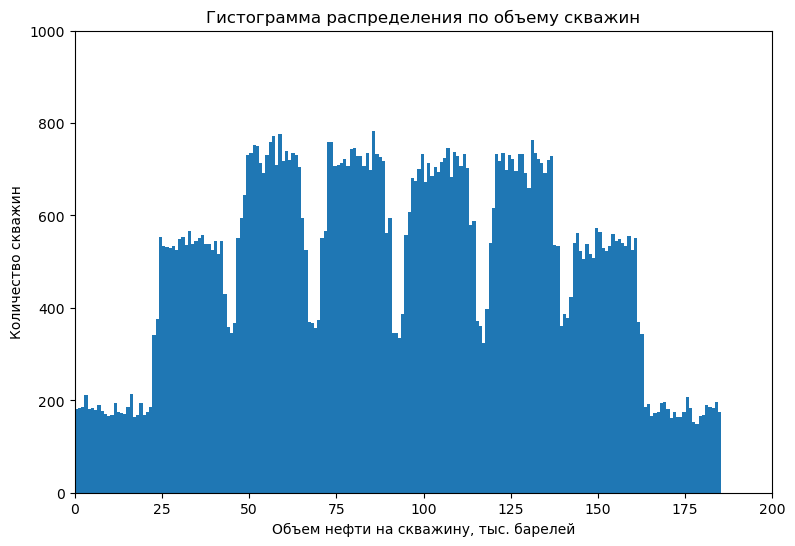

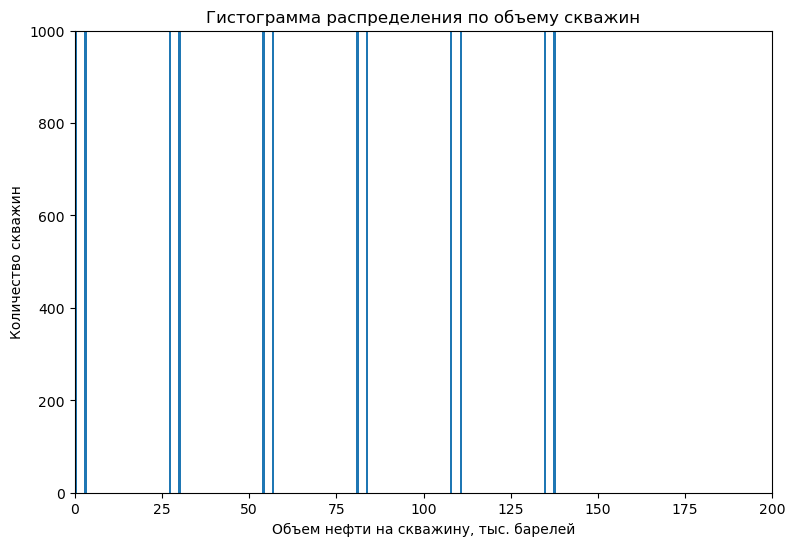

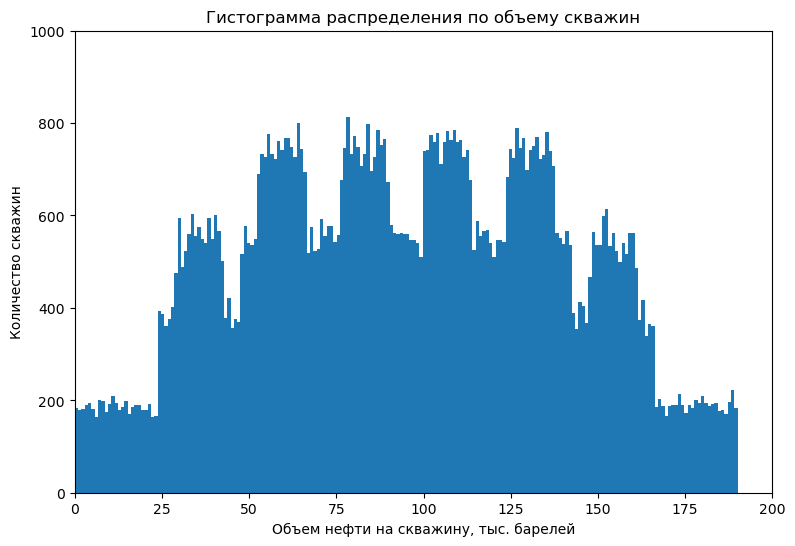

In [18]:
for i in range(3):
    plt.figure(figsize=[9, 6])
    plt.hist(data[i]['product'], bins=200)
    plt.xlim([0, 200])
    plt.ylim([0, 1000])
    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")
    plt.title("Гистограмма распределения по объему скважин")
    plt.show()

У первого и третьего датасета распределение скважин близкое к нормальному. Во втором датасете данные имеют странное распределение: с шагом по 20 -30  распределены все 10000 значений. Вполне возможно, что часть нулевых скважин просто еще не имеют разведданных

### Удаление лишнего столбца `id`

Столбец `id` c с тектстовыми идентификаторами скважин можно удалить, т.к. данные в ней будут мешать обучению моделей

In [19]:
data_0 = data_0.drop(['id'], axis=1)
data_1 = data_1.drop(['id'], axis=1)
data_2 = data_2.drop(['id'], axis=1)

### Вывод

Данные подготовлены к дальнейшему исследованию:

- созданы датафрейма `data_0`, `data_1` и `data_2`
- удален столбец `id` из каждого из датафреймов

## Обучение и проверка модели

### Разбиение данных на обучающую и валидационную выборки в соотношении 75:25.

Для разбиения напишем функцию `split_scaler`, которая формирует датасеты для признаков и целевого признака, разбивает выборку на обучающую и валидационную выборки в соотношении 75:25 и стандартизирует численные признаки методом StandardScaler(), а так же выводит на экран информацию о  разбиении датасета.

In [20]:
# в качестве аргументов подается датасет, список численных признаков и название целевого признака
def split_scaler(data, numeric, target):

    features = data.drop([target], axis=1)
    target = data[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM)

    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    print(f"Размер выборки после разбиения.\n")
    print(
        f"Обучающая выборка: признаки - {features_train.shape}, целевой признак - {target_train.shape}\n"
    )
    print(
        f"Валидационная выборка: признаки - {features_valid.shape}, целевой признак - {target_valid.shape}"
    )

    return (features_train, features_valid, target_train, target_valid)

Применим функцию `split_scaler` к датасетам `data_0`, `data_1` и `data_2`.

In [21]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_scaler(
    data_0, ['f0', 'f1', 'f2'], 'product')

Размер выборки после разбиения.

Обучающая выборка: признаки - (75000, 3), целевой признак - (75000,)

Валидационная выборка: признаки - (25000, 3), целевой признак - (25000,)


In [22]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_scaler(
    data_1, ['f0', 'f1', 'f2'], 'product')

Размер выборки после разбиения.

Обучающая выборка: признаки - (75000, 3), целевой признак - (75000,)

Валидационная выборка: признаки - (25000, 3), целевой признак - (25000,)


In [23]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_scaler(
    data_2, ['f0', 'f1', 'f2'], 'product')

Размер выборки после разбиения.

Обучающая выборка: признаки - (75000, 3), целевой признак - (75000,)

Валидационная выборка: признаки - (25000, 3), целевой признак - (25000,)


**Исходные датасеты разделены правильно**

### Обучение модели и предсказания на валидационной выборке и сохранение предсказаний на валидационной выборке

Подбор наилучших гиперпараметов для каждого из разделенных датасетов при помощи `GridSearchCV`

In [24]:
def grid_best_param(features_train, target_train):
    model_grid = LinearRegression()
    parameters = {
        'fit_intercept': [True, False],
        'copy_X': [True, False]
    }
    grid = GridSearchCV(model_grid, parameters)
    grid.fit(features_train, target_train)
    return grid.best_params_

In [25]:
print(
    'Лучшие гиперпараметры линейной регрессии для разделенного на выборки датасета data_0:\n',
    grid_best_param(features_train_0, target_train_0))

Лучшие гиперпараметры линейной регрессии для разделенного на выборки датасета data_0:
 {'copy_X': True, 'fit_intercept': True}


In [26]:
print(
    'Лучшие гиперпараметры линейной регрессии для разделенного на выборки датасета data_1:\n',
    grid_best_param(features_train_1, target_train_1))

Лучшие гиперпараметры линейной регрессии для разделенного на выборки датасета data_1:
 {'copy_X': True, 'fit_intercept': True}


In [27]:
print(
    'Лучшие гиперпараметры линейной регрессии для разделенного на выборки датасета data_2:\n',
    grid_best_param(features_train_2, target_train_2))

Лучшие гиперпараметры линейной регрессии для разделенного на выборки датасета data_2:
 {'copy_X': True, 'fit_intercept': True}


**Обучение, предсаказание и сохранение результатов.**

In [28]:
model_regression_0 = LinearRegression(copy_X=True,
                                      fit_intercept=True)
model_regression_0.fit(features_train_0, target_train_0)
predictions_model_regression_0 = model_regression_0.predict(features_valid_0)
rmse_0 = round(
    mean_squared_error(target_valid_0, predictions_model_regression_0)**0.5, 3)
# средняя предсказанного сырья
mean_predict_valid_0 = round(predictions_model_regression_0.mean(), 3)

In [29]:
model_regression_1 = LinearRegression(copy_X=True,
                                      fit_intercept=True)
model_regression_1.fit(features_train_1, target_train_1)
predictions_model_regression_1 = model_regression_1.predict(features_valid_1)
rmse_1 = round(
    mean_squared_error(target_valid_1, predictions_model_regression_1)**0.5, 3)
# средняя предсказанного сырья
mean_predict_valid_1 = round(predictions_model_regression_1.mean(), 3)

In [30]:
model_regression_2 = LinearRegression(
    copy_X=True, fit_intercept=True)
model_regression_2.fit(features_train_2, target_train_2)
predictions_model_regression_2 = model_regression_2.predict(features_valid_2)
rmse_2 = round(mean_squared_error(
    target_valid_2, predictions_model_regression_2)**0.5, 3)
# средняя предсказанного сырья
mean_predict_valid_2 = round(predictions_model_regression_2.mean(), 3)

### Полученные результаты среднего запаса предсказанного сырья и RMSE модели

In [31]:
print('Средний запас предсказанного сырья в регионе 1:',
      mean_predict_valid_0, 'тыс. баррелей, RMSE:', rmse_0)
print('Средний запас предсказанного сырья в регионе 2:',
      mean_predict_valid_1, 'тыс. баррелей, RMSE:', rmse_1)
print('Средний запас предсказанного сырья в регионе 3:',
      mean_predict_valid_2, 'тыс. баррелей, RMSE:', rmse_2)

Средний запас предсказанного сырья в регионе 1: 92.593 тыс. баррелей, RMSE: 37.579
Средний запас предсказанного сырья в регионе 2: 68.729 тыс. баррелей, RMSE: 0.893
Средний запас предсказанного сырья в регионе 3: 94.965 тыс. баррелей, RMSE: 40.03


### Вывод

**Самый большой регион по срезнему предсказанному запасу сырья это Регион 3 - 94.965 тыс. баррелей, но у него так же самая большое значение ошибки предсказания RMSE: 40.03.**

**Самый лучший регион по RMSE это Регион 2.**

## Подготовка к расчёту прибыли

### Сохранение ключевыx значений для расчётов в отдельных переменных

In [32]:
BUDGET = 10_000_000_000  # общий бюджет
POINTS = 500  # исследуемые 500 точек
BEST_POINTS = 200  # 200 лучших точек
PRICE_PER_BARREL = 450_000  # цена за 1000 баррелей

### Рассчёт достаточного объёма сырья для безубыточной разработки новой скважины и сравнение полученного объёма сырья со средним запасом в каждом регионе.

Средний реальный запас сырья в каждом регионе.

In [33]:
real_mean_0 = round(data_0['product'].mean(), 3)
print('Средний реальный запас сырья в регионе 1:', real_mean_0, 'тыс. баррелей')
real_mean_1 = round(data_1['product'].mean(), 3)
print('Средний реальный запас сырья в регионе 2:', real_mean_1, 'тыс. баррелей')
real_mean_2 = round(data_2['product'].mean(), 3)
print('Средний реальный запас сырья в регионе 3:', real_mean_2, 'тыс. баррелей')

Средний реальный запас сырья в регионе 1: 92.5 тыс. баррелей
Средний реальный запас сырья в регионе 2: 68.825 тыс. баррелей
Средний реальный запас сырья в регионе 3: 95.0 тыс. баррелей


Общий итог по реальному среднему запасу и предсказанному

In [34]:
data_rmse = {
    'Средний реальный запас сырья': [real_mean_0, real_mean_1, real_mean_2],
    'Средний запас предсказанного сырья':
    [mean_predict_valid_0, mean_predict_valid_1, mean_predict_valid_2],
    'RMSE': [rmse_0, rmse_1, rmse_2]
}

data_result = pd.DataFrame(
    data_rmse,
    index=['Регион 1 (data_0)', 'Регион 2 (data_1)', 'Регион 3 (data_2)'])
data_result

,Средний реальный запас сырья,Средний запас предсказанного сырья,RMSE
Регион 1 (data_0),92.500,92.593,37.579
Регион 2 (data_1),68.825,68.729,0.893
Регион 3 (data_2),95.000,94.965,40.030


Количество тыс. баррелей в сутки необходимое для выхода в 0 (точка безубыточности)

In [35]:
zero_point = round(BUDGET / PRICE_PER_BARREL, 3)
print('Точка безубыточности:', zero_point, 'тыс. баррелей сутки')

Точка безубыточности: 22222.222 тыс. баррелей сутки


Средний запас сырья для безубыточного функционирования на 200 лучших точек.

In [36]:
avg_best = round(zero_point / BEST_POINTS, 3)
print('Средний запас сырья для безубыточного функционирования:',
      avg_best, 'тыс. баррелей сутки')

Средний запас сырья для безубыточного функционирования: 111.111 тыс. баррелей сутки


### Вывод

**Реальные и предсказанные средние объемы сырья меньше среднего запаса для безубытка...**

## Расчёт прибыли и рисков 

### Функция `profit` для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [37]:
def profit(target, probabilities):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities).reset_index(drop=True)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:BEST_POINTS]
    return round(
        ((PRICE_PER_BARREL * selected.sum()) - BUDGET) / 1_000_000_000, 3)

Вывод данных на экран

In [38]:
print(
    'Прибыль для 200 лучших скважин на основании реальных и предсказанных данных для Региона 1 (data_0)',
    profit(target_valid_0, predictions_model_regression_0), 'млрд. рублей.')
print(
    'Прибыль для 200 лучших скважин на основании реальных и предсказанных данных для Региона 2 (data_1)',
    profit(target_valid_1, predictions_model_regression_1), 'млрд. рублей.')
print(
    'Прибыль для 200 лучших скважин на основании реальных и предсказанных данных для Региона 3 (data_2)',
    profit(target_valid_2, predictions_model_regression_2), 'млрд. рублей.')

Прибыль для 200 лучших скважин на основании реальных и предсказанных данных для Региона 1 (data_0) 3.321 млрд. рублей.
Прибыль для 200 лучших скважин на основании реальных и предсказанных данных для Региона 2 (data_1) 2.415 млрд. рублей.
Прибыль для 200 лучших скважин на основании реальных и предсказанных данных для Региона 3 (data_2) 2.71 млрд. рублей.


**Самый прибыльный регион - Регион 1, может принести прибыль в 3.321 млрд. рублей**

**Наименьшая прибыль у Региона 2 - 2.415 млрд. рублей** 

### Расчет рисков и прибыли для каждого региона с помощью техники `Bootstrap`.

In [39]:
state = np.random.RandomState(12345)


def bootstrap(target, probabilities):
    risk_default = 0.025
    values = []
    for i in range(1000):
        target_subsample = pd.Series(target).reset_index(drop=True).sample(
            n=POINTS, replace=True, random_state=state)
        probs_subsample = pd.Series(probabilities).reset_index(
            drop=True)[target_subsample.index]
        income = profit(target_subsample, probs_subsample)
        values.append(income)

    values = pd.Series(values)
    lower = round(values.quantile(0.025), 3)
    upper = round(values.quantile(0.975), 3)
    average = round(values.mean(), 3)
    risk = round((values < 0).mean(), 3)
    print(f"Средняя прибыль: {average} млрд. рублей \n")
    print(
        f"95% доверительный интервал от {lower}(0.025 квантиль) до {upper}(0.975 квантиль) млрд. рублей \n"
    )
    print(f"Риск убытков: {risk}  \n")
    print(
        f"Вероятность убытков в отдельно взятом регионе должна быть меньше 2.5 %  \n"
    )
    if risk < risk_default:
        print("Данный регион прибыльный")
    else:
        print("Данный регион убыточный")

#### Регион 1

In [40]:
bootstrap(target_valid_0, predictions_model_regression_0)

Средняя прибыль: 0.396 млрд. рублей 

95% доверительный интервал от -0.111(0.025 квантиль) до 0.91(0.975 квантиль) млрд. рублей 

Риск убытков: 0.069  

Вероятность убытков в отдельно взятом регионе должна быть меньше 2.5 %  

Данный регион убыточный


#### Регион 2

In [41]:
bootstrap(target_valid_1, predictions_model_regression_1)

Средняя прибыль: 0.461 млрд. рублей 

95% доверительный интервал от 0.078(0.025 квантиль) до 0.863(0.975 квантиль) млрд. рублей 

Риск убытков: 0.007  

Вероятность убытков в отдельно взятом регионе должна быть меньше 2.5 %  

Данный регион прибыльный


#### Регион 3

In [42]:
bootstrap(target_valid_2, predictions_model_regression_2)

Средняя прибыль: 0.393 млрд. рублей 

95% доверительный интервал от -0.112(0.025 квантиль) до 0.934(0.975 квантиль) млрд. рублей 

Риск убытков: 0.065  

Вероятность убытков в отдельно взятом регионе должна быть меньше 2.5 %  

Данный регион убыточный


### Вывод

**В результате расчета средней прибыли, доверительных интервалов в зависимости от допустимого риска 2.5% для рабработки можно предлодить Регион 2.**

## Общий вывод

1. Проведена предобработка датасетов;
    - удален стоблец `id`, который мешал дальнейшему анализу.

2. Обучена модель линейной регрессии. На основании предсказаниий были получены следующие значения:

   - Средний запас предсказанного сырья в регионе 1: 92.593 тыс. баррелей, RMSE: 37.579
   - Средний запас предсказанного сырья в регионе 2: 68.729 тыс. баррелей, RMSE: 0.893
   - Средний запас предсказанного сырья в регионе 3: 94.965 тыс. баррелей, RMSE: 40.03
   
   Самый большой регион по срезнему предсказанному запасу сырья это Регион 3 - 94.965 тыс. баррелей, но у него так же самая большое значение ошибки предсказания RMSE: 40.03.

   Самый лучший регион по RMSE это Регион 2.
  
3. Рассчитан средний запас сырья для безубыточного функционирования скважины: 111.111 тыс. баррелей сутки 

   Реальные и предсказанные средние объемы сырья меньше среднего запаса для безубытка...
   
   - Прибыль для 200 лучших скважин на основании реальных и предсказанных данных для Региона 1 (data_0) 3.321 млрд. рублей.
   - Прибыль для 200 лучших скважин на основании реальных и предсказанных данных для Региона 2 (data_1) 2.415 млрд. рублей.
   - Прибыль для 200 лучших скважин на основании реальных и предсказанных данных для Региона 3 (data_2) 2.71 млрд. рублей.

   Самый прибыльный регион - Регион 1, может принести прибыль в 3.321 млрд. рублей

   Наименьшая прибыль у Региона 2 - 2.415 млрд. рублей

   
4. По прогнозам сделанным с помощью техники Bootstrap: 
 
   - Основной критерий - вероятность убытков - 2.5 %. Регион  2 имеет самую низкую вероятность убытков, всего 0.7%. И более узкий доверительный интервал, и соответственно более высокую среднюю прибыль;

   - Остальные регионы имеют риск, превышающий основной критерий, поэтому рассмотрены быть не могут.
   
**Для разработки рекомендован Регион 2**

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован